<hr>

**Authors:**  Thomas Duthoit<br>
**Copyright:** 2022 Thomas Duthoit <br>
**License:** MIT

<hr>

<h1 style="text-align: center;">Anomaly detection in satellite image time series related to forest monitoring</h1>

<hr>

## Data used in this notebook

| Product Description | WEkEO HDA ID | WEkEO metadata |
|:--------------------:|:-----------------:|:-----------------:|
| Sentinel-2 MSI level-1C | EO:EUM:DAT:0411 | <a href="https://navigator.eumetsat.int/product/EO:EUM:DAT:SENTINEL-3:SL_1_RBT___NTC?query=SLSTR&s=advanced" target="_blank">link</a> | EO:ESA:DAT:SENTINEL-2:MSI | <a href="https://www.wekeo.eu/data?view=dataset&dataset=EO%3AESA%3ADAT%3ASENTINEL-2%3AMSI" target="_blank">link</a> |

## Learning outcomes

At the end of this notebook you will know;
* How to download Sentinel-2 data.
* How you can use Sentinel-2 data to monitor forests.
* How to detect anomalies in multiple Sentinel-2 times series.
* How to interpret/analyse the results obtained.

## Further resources

- The SLIC superpixel segmentation : https://www.iro.umontreal.ca/~mignotte/IFT6150/Articles/SLIC_Superpixels.pdf
- BFAST article : http://bfast.r-forge.r-project.org/RSE_ChangeDetection_InPress_JanVerbesselt.pdf
- BFASTMonitor documentation : https://bfast.readthedocs.io/en/latest/

## Notebook outline
    
 1. [Load Sentinel-2 level 1C tiles on WEkEO's catalogue](#section1)
 2. [Extract wanted files and crop them to area of interest](#section2)
 3. [Generate the time series : compute NDVI and cloud mask](#section3)
 4. [Superpixel segmentation of the area of interest](#section4)
 5. [Compute the NDVI mean and cloud mask mean for each superpixel](#section5)
 6. [Filtering : keep only forest superpixels](#section6)
 7. [Apply BFAST algorithm to all remaining time series](#section7)
 8. [USE CASE 1 : Forest fire detection in Var region (France)](#section8)
 9. [USE CASE 2 : Monitor parasite attacks on trees, example in Lot region (France)](#section9)


<hr>

In [7]:
# library imports
import numpy as np
import os
import sys
import warnings
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.cm as cmaps
import matplotlib.colors as clr
from IPython.display import clear_output


import geopandas as gpd
import pandas as pd

# for plotting
import seaborn as sn

from sentinelhub import BBox, CRS
from tqdm.notebook import tqdm
import rasterio as rio
from rasterio.mask import mask

# to retrieve tile maps from the internet
import contextily as cx 

import imageio

import shapely.geometry as shp

from math import ceil

# # to manipulate satellite data
from eolearn.core import FeatureType, EOTask, EOPatch, OverwritePermission
from eolearn.geometry.transformations import RasterToVectorTask
from eolearn.geometry.superpixel import SlicSegmentationTask

# # math processes
from scipy import stats, ndimage

# # bfast package
from bfast import BFASTMonitor
from bfast.monitor.utils import crop_data_dates

# # run functions
%run helper_functions.ipynb

from PIL import Image

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In this notebook we will deal with two different use cases, presented in [section 8](#section8) and [section 9](#section9).
For both, the processing chain described throughout sections 1 to 7 of this notebook is identical. To switch from one use case to the other, you just need to change the `use_case` variable in the cell following this short introductory paragraph. Either :
- 'Var' string for use case 1 or 
- 'Lot' string for use case 2. 

Enjoy reading!

In [2]:
use_case = 'Var' #use case 1

# use_case = 'Lot' #use case 2

# <a id='section1'></a>1. Load Sentinel-2 level 1C tiles on WEkEO's catalogue
[Back to top](#TOC_TOP)


The first step is to download the data from the <a href="https://www.wekeo.eu/data?view=catalogue&initial=1" target="_blank">WEkEO Catalogue</a>. To do so, we can run a small python script which summarizes the all the options for your use :
- `datasetId` : The ID of the dataset you need, you can find it in the <a href="https://www.wekeo.eu/data?view=viewer&t=1655942400000&z=0&center=0%2C24.4152&zoom=10.91&initial=1" target="_blank">WEkEO data viewer</a>,
- `boundingBoxValues` : The coordinates of the upper left corner and the lower right corner of the area of interest,
- `dateRangeSelectValues` : The start and end of the period of interest,
- and other options depending on the type of dataset you choose.

The following cell is an example you can follow but if you need any further help with the Harmonized Data Access (HDA), WEkEO provides a well guided documentation  <a href="https://www.wekeo.eu/docs/harmonised-data-access-api" target="_blank">here</a>.

# <a id='section2'></a>2. Extract wanted files and crop them to area of interest
[Back to top](#TOC_TOP)

The Sentinel-2 satellites are equiped with a multi-spectral instrument that has 13 spectral bands. Bands have resolutions from 10 to 60 meters and their wavelength goes from the visible to the shortwave infrared. Here is a table that summarizes everything : 

| Sentinel-2 Bands | Central Wavelength (nm) | Resolution (m) |
|:--------------------:|:-----------------:|:-----------------:|
| Band 1 - Coastal aerosol | 443 | 60 |
| Band 2 - Blue | 490 | 10 
| Band 3 - Green | 560 | 10 |
| Band 4 - Red | 665 | 10 |
| Band 5 - Vegetation Red Edge | 705 | 20 |
| Band 6 - Vegetation Red Edge | 740 | 20 |
| Band 7 - Vegetation Red Edge | 783 | 20 |
| Band 8 - Near Infrared | 842 | 10 |
| Band 8 - Vegetation Red Edge | 865 | 20 |
| Band 9 - Water vapour | 945 | 60 |
| Band 10 - Short-wave Infrared - Cirrus | 1375 | 60 |
| Band 11 - Short-wave Infrared | 1610 | 20 |
| Band 12 - Short-wave Infrared | 2190 | 20 |

**Important:** In this section, execution has been done upstream because of the huge size of the data. Still, I will explain how to proceed and provide code that you may use for your own purpose. I will display the code into raw cells.

Once all the data is downloaded in [section 1](#section1), we need to unzip the files that will be usefull to our use cases :

- __*B04.jp2__ : The red band (band 4)
- __*B08.jp2__ : The near infrared band (band 8)
- __*B00.gml__ : shapefile that indicates which region of the tile is covered by clouds

To do so, you will have to create a list of zip files (`zip_files`) that you just downloaded, go through every single one of them and extract the three needed file as follows :

Now we can reduce the size of our band4 and band8 JP2 image. To do so, it is necessary to use the *mask* function from the **rasterio.mask** package. <a href="https://rasterio.readthedocs.io/en/latest/topics/masking-by-shapefile.html" target="_blank">Here</a> is an example of how you can crop and image to obtain a smaller image of your region of interest.

\
Here is a small cell code that guides you on how doing it :

The result of both processes gives us everything we need to start our study. The data is stored in the `S2 data` folder. The next step is to store the names of all these files into a list 

**Note:** You can go through the `S2 data` folder and see the files for both use cases (Var & Lot). Each file has been ordered by year, date and type of data 

In [11]:
#empty file list
spatial_files = []

# path
directory = 'S2 data/' + use_case + '/'

# walk through directory
for path, subdirs, files in os.walk(directory):
    for name in sorted(files):
        if name[-3:] == "gml" or name[-3:] == "jp2":
            file_path = os.path.join(path, name)
            spatial_files.append(file_path)
            
# sort file list
spatial_files = sorted(spatial_files)


print('number of files = ', len(spatial_files))
print('number of acquisitions = ', int(len(spatial_files)/3))

number of files =  870
number of acquisitions =  290


We have now a list _`spatial_files`_ containing all file paths

# <a id='section3'></a>3. Generate the time series : compute NDVI and cloud mask
[Back to top](#TOC_TOP)

The NDVI is the normalized difference vegetation index. It is a simple indicator that is very useful to target whether or not the area contains live green vegetation. It is commonly used in earth observation and especially land monitoring. The NDVI is calculated thanks to band4 (RED) and band8 (NIR) as follows :

<center>$NDVI = \frac{NIR - RED}{NIR + RED}$</center>

\
The following piece of code will run through every single file and compute the NDVI and the cloud mask for every acquisition. Here is an explanation of the important outputs of the cell :
    
- `ndvi_stack` : This matrix contains the NDVI of the regions of interest computed over every single acquisition
- `clc_stack` : This matrix contains the cloud mask (1 if the pixel is covered by a cloud, 0 otherwise) for every acquisition
- `bbox` : Bounding box of the area of interest
- `timestamp` : List of of dates corresponding to the S2 acquisitions

In [12]:
# set bounding boxes of both use cases
if use_case == 'Var':
    aoi = [6.39, 43.31, 6.44, 43.36] #WSG84 CRS
else:
    aoi = [1.52, 44.45, 1.62, 44.50] #WSG84 CRS
    
# create a bounding box object from the aoi coordinates
bbox = BBox(aoi, CRS.WGS84)

# Transform the coordinates to UTM 31N
bbox = bbox.transform(CRS.UTM_31N)

timestamp = []
for i in tqdm(range(0, len(spatial_files), 3)):
    year = spatial_files[i][12:16]
    month = spatial_files[i][17:19]
    day = spatial_files[i][19:21]

    # open band4 et band8 acquisition
    band4 = rio.open(spatial_files[i+1])
    band8 = rio.open(spatial_files[i+2])
    
    # convert to int16
    band4_int = band4.read().squeeze().astype('int16')
    band8_int = band8.read().squeeze().astype('int16')

    # compute ndvi
    ndvi = ((band8_int - band4_int) / (band8_int + band4_int)).astype('float32')
    try:
        # open cloud shapes
        clm = gpd.read_file(spatial_files[i])

        # keep shapes intersecting aoi
        clm_clipped = clm.intersection(bbox.geometry)
        clm_clipped = clm_clipped[~clm_clipped.is_empty]
        
        if len(clm_clipped.index) == 0:
            # case : no cloud coverage
            clip_clm = np.zeros(band4_int.shape)
        
        else:
            # case : cloud coverage
            clip_clm, _ = mask(band4, clm_clipped)

        # set pixel to 1 if covered by cloud, 0 otherwise
        clc_mask = np.where(clip_clm <= 0, 0, 1).astype('uint8')

    except ValueError:
        # case no clouds on whole sentinel2 tile
        clip_clm = np.zeros(band4_int.shape)
        clc_mask = np.where(clip_clm <= 0, 0, 1).astype('uint8')
    
    if i==0:
        # initialise variables
        ndvi_stack = np.expand_dims(ndvi, axis=0)
        clc_mask_stack = np.expand_dims(clc_mask.squeeze(), axis=0)
    else:
        # stack newly computed ndvi and cloud mask
        ndvi_stack = np.vstack((ndvi_stack, np.expand_dims(ndvi, axis=0)))
        clc_mask_stack = np.vstack((clc_mask_stack, np.expand_dims(clc_mask.squeeze(), axis=0)))
    
    # append new timestamp
    timestamp.append(datetime(int(year), int(month), int(day)))

  0%|          | 0/290 [00:00<?, ?it/s]

In [13]:
print(ndvi_stack.shape)
print(clc_mask_stack.shape)

(290, 572, 383)
(290, 572, 383)


Both of these outputs are three-dimensional. The first dimension corresponds to the number of acquisition over the period. Second and third dimensions are respectively the number of horizontal and vertical pixels of the area of interest.
\
To gather all these varibales (NDVI, cloud mask, bbox and timestamp) we can create an Earth Observation Patch from the <a href="https://eo-learn.readthedocs.io/en/latest/examples/core/CoreOverview.html" target="_blank">EO-Learn package</a> :

In [14]:
# initialise eopatch
eopatch = EOPatch()

# fill eopatch
eopatch[FeatureType.DATA, "NDVI"] = np.expand_dims(ndvi_stack, axis=3)
eopatch[FeatureType.MASK, "CLM"] = np.expand_dims(clc_mask_stack, axis=3)
eopatch[FeatureType.BBOX] = BBox(bbox.geometry.bounds, CRS.UTM_31N)
eopatch[FeatureType.TIMESTAMP] = timestamp

# save eopatch
eopatch.save('Patches/' + use_case + '/Raw_data')

eopatch

EOPatch(
  data={
    NDVI: numpy.ndarray(shape=(290, 572, 383, 1), dtype=float32)
  }
  mask={
    CLM: numpy.ndarray(shape=(290, 572, 383, 1), dtype=uint8)
  }
  bbox=BBox(((774929.8271692572, 4800823.106411173), (778756.0391848743, 4806542.435500089)), crs=CRS('32631'))
  timestamp=[datetime.datetime(2018, 1, 5, 0, 0), ..., datetime.datetime(2021, 12, 30, 0, 0)], length=290
)

# <a id='section4'></a>4. Superpixel segmentation of the area of interest
[Back to top](#TOC_TOP)


Segmenting in superpixels has two major benefits. The first one is that we considerably reduce the dimension and so the number of time series we will have to process. The second reason is that, from an analytic point of view, it has no real benefit to proceed pixel by pixel.

Here is how we are going to proceed :
1. We compute the <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.zscore.html" target="_blank">z-score</a> of each value in each time series. Result will be stored as `NDVI_STANDARD`
2. As for now, one pixel = one time series. Then, we execute the SLIC segmentation on `NDVI_STANDARD` to group our time series into superpixels.
    - `n_segments` : The approximate number of superpixels we want
    - `compactness` : shape of superpixels. A high value will make them more square/cubic. A low value will take the space proximity less into account
    - `sigma` : Width of Gaussian smoothing kernel for pre-processing for each dimension of the image. 0 means no smoothing
    - more to see <a href="https://scikit-image.org/docs/dev/api/skimage.segmentation.html#skimage.segmentation.slic" target="_blank">here</a>
33. Now that we have reduced our dimension (e.g. one superpixel = multiple time series) we can transform our superpixels into vector shapes. Thereby, it will be easier to process for the next steps.

The following cell sets the different tasks for further execution.

In [15]:
# setting the slic segmentation task
slic_segmentation_task = SlicSegmentationTask((FeatureType.DATA, 'NDVI_STANDARD'), 
                                       (FeatureType.MASK_TIMELESS, 'SUPER_PIXELS'),
                                      n_segments=5000, compactness=0.0001, sigma=1)

# setting the raster to vector task
raster_to_vector_task = RasterToVectorTask(features=(FeatureType.MASK_TIMELESS, 'SUPER_PIXELS', 'SUPER_PIXELS'))

The tasks are now set and ready to be executed. In the next cell, we apply the 3 steps described at the beginning of this section

In [16]:
# Load data
eopatch = EOPatch.load('Patches/' + use_case + '/Raw_data/')

# standardize the NDVI
eopatch.data['NDVI_STANDARD'] = stats.zscore(eopatch.data['NDVI'], nan_policy='omit')

# freeing memory
del eopatch.data['NDVI']

# execute the superpixel task
eopatch = slic_segmentation_task.execute(eopatch)
eopatch.mask_timeless['SUPER_PIXELS'] = eopatch.mask_timeless['SUPER_PIXELS'].astype(np.int32)

# execute the raster to vector task
eopatch = raster_to_vector_task.execute(eopatch)

# save the processed eopatch
eopatch.save("Patches/" + use_case + "/Processed data")

eopatch

EOPatch(
  data={
    NDVI_STANDARD: numpy.ndarray(shape=(290, 572, 383, 1), dtype=float32)
  }
  mask={
    CLM: numpy.ndarray(shape=(290, 572, 383, 1), dtype=uint8)
  }
  mask_timeless={
    SUPER_PIXELS: numpy.ndarray(shape=(572, 383, 1), dtype=int32)
  }
  vector_timeless={
    SUPER_PIXELS: geopandas.GeoDataFrame(columns=['VALUE', 'geometry'], length=4227, crs=EPSG:32631)
  }
  bbox=BBox(((774929.8271692572, 4800823.106411173), (778756.0391848743, 4806542.435500089)), crs=CRS('32631'))
  timestamp=[datetime.datetime(2018, 1, 5, 0, 0), ..., datetime.datetime(2021, 12, 30, 0, 0)], length=290
)

The processed data is now stored in `Patches/use_case/Processed data`

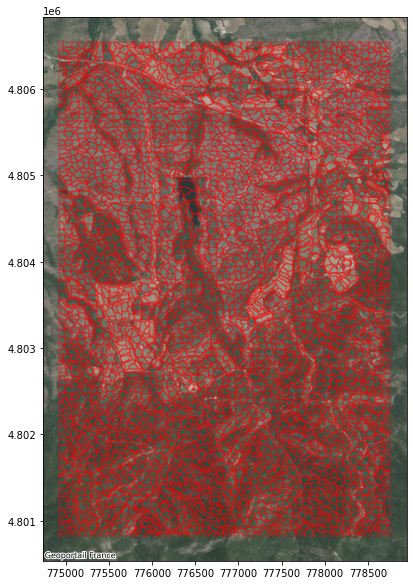

In [9]:
# print result of the segmentation
fig, ax = plt.subplots(figsize=(15, 10))
eopatch.vector_timeless['SUPER_PIXELS'].geometry.boundary.plot(ax=ax, color=None, edgecolor='red', linewidth=0.4)
cx.add_basemap(ax=ax, crs=CRS.UTM_31N.epsg, source=cx.providers.GeoportailFrance.orthos)

The previous plot is the result of our superpixel segmentation. There is a total of 4227 superpixels. Remember that at first our area of interest was 572p by 383p, meaning we had a total of 219 076 pixels e.g. time series. 
By applying the superpixel segmentation we our now down to 4227 time series, a significant dimension reduction. How ? By applying a the mean on all pixels belonging to the same superpixel, which is the content of the following section.

# <a id='section5'></a>5. Compute the NDVI mean and cloud mask mean for each superpixel
[Back to top](#TOC_TOP)

In this section, we are going to construct our time series. Each superpixel will have his own time serie from January 2018 to December 2021. To do so, we need to compute the NDVI mean of every pixel contained in each superpixel. We proceed the same way for the cloud mask. These are the two first steps of the `get_valid_data` method :

    1. Compute the NDVI mean of all pixels belonging to the same superpixel
    2. Compute cloud mask mean of all pixels belonging to the same superpixel


However, it is possible that for a specific date, there is too much cloud coverage on a superpixel, meaning that the NDVI value computed is not relevant. Thereby, we need to add a third step to the method :

    3. If the mean of the cloud coverage of one superpixel at a specific date is superior to 0.2, then we set to NaN the NDVI mean of the corresponding superpixel and date.

If needed, you can check the `get_valid_data` implementation in `helper_functions.ipynb` to have step to step details.

In [3]:
# load patch
eopatch = EOPatch.load("Patches/" + use_case + "/Processed data")

# filter data considering the cloud mask
valid_data, dates = get_valid_data(eopatch=eopatch)
valid_data.shape

(290, 4227)

We have now constructed our NDVI time series.

- `valid_data` is shape [290, 4227]. 290 is the number of Sentinel-2 acquisition (e.g. dates) and 4227 is the number of superpixels. Each superpixel has his own NDVI time series. 
- `dates` is a list of the 290 dates.

<AxesSubplot:xlabel='Date'>

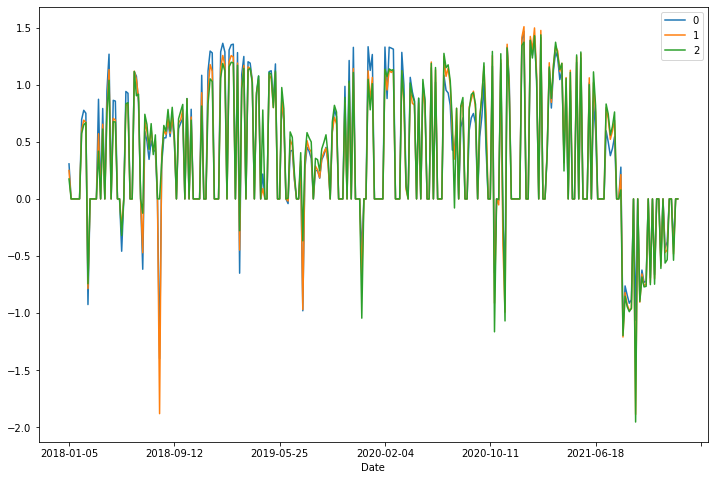

In [4]:
# plot of a time series

# dataframe of all time series
time_series = pd.DataFrame(valid_data)
time_series['Date'] = dates
time_series = time_series.set_index('Date')
time_series = time_series.fillna(0)

series_to_plot = 3
fig, ax = plt.subplots(figsize=(12,8))
time_series[list(range(series_to_plot))].plot(ax=ax)

The previous plot shows the time series built for the first three superpixels. NaN values (e.g. cloudy superpixels at corresponding date) have been filled to 0. We can already observe something wrong happing during the 2021 summer compared to the previous year. Let's check it out.

# <a id='section6'></a>6. Filtering : keep only forest superpixels
[Back to top](#TOC_TOP)

In the previous section, we have segmented the whole area of interest, even the pixel that do not cover forest. This means that some of our time series are irrelevant for our two use cases. In this section, I show you can apply a filter, implemented in `get_forest_time_series`, in order to only keep the forest time series.

- `shapefile` : file where is stored the polygons that delimit the forest area in the _use_case_ departement (France).
- `filter_percentage` : percentage to which we keep a time series. If one superpixel is covered of this percentage or more of forest area, it is kept. Otherwise, it is dropped. Default is 0.8.


In [5]:
# extract forest time series
time_series_forest, ts_indices_preserved = get_forest_time_series(eopatch=eopatch, shapefile='Shapefiles/Forêts ' + use_case + '/Formation_végétale_' + use_case + '.shp', filter_percentage=0.8)

85.17 % of time series preserved


The next plot shows all the superpixels (e.g. time series) that conver a forest zone of our area of interest. Only these time series are retained for the future development. As specified above, 85.17% of the time series are forest time series. This means that we are down to 3600 superpixels now

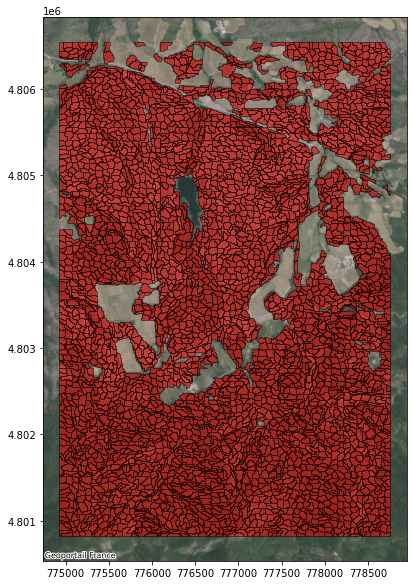

In [6]:
# plotting the forest time series
plot_forest_sp(time_series_forest)

# <a id='section7'></a>7. Apply BFAST algorithm to all remaining time series
[Back to top](#TOC_TOP)

There are several ways to monitor disturbances in time series models. In our case we are going to use a python implementation of the Breaks For Additive Season and Trend monitor known as the BFAST monitor. BFAST is an algorithm that splits a time series into a Seasonal, Trend and remainder component in order to detect what we call breakpoints (e.g. disturbances, anomalies). Further resources are available at the top of this Notebook about how the algorithm works.
\
The following diagram show in a few steps the process of the <a href="https://bfast.readthedocs.io/en/latest/" target="_blank">BFASTMonitor</a> :

    1. It takes a time series as an input
    2. The user specifies an training and monitoring period :
        - training period : Period of time that will be used as a reference
        - monitoring period : Period of time on which we are detecting breakpoints
    3. The training period is split in 3 components : Season, Trend and remainder (comparable to noise)
    4. BFAST is ran on the training period and extracts a stable subset 
    5. A model is predicted with the stable subset along the monitoring period 
    6. Our time series and the model fitted are compared and if a breakpoint is detected, the algorithm returns the exact date of the breakpoint appearance
<p align="center">
     <img src='./Images/bfast.png'>
</p>

The following cells is a data preparation before executing BFAST :
- `end_train` : date indicating the end of the training period. Beginning of training period is always the first date of the dataset. Here first acquisition of 2018.
- `start_monitor` : date indicating the start of monitoring period. Has to be later than `end_train`
- `end_monitor`: date indicating the end of monitoring period. 
- there are more parameters explained <a href="https://bfast.readthedocs.io/en/latest/" target="_blank">here</a>

In [7]:
# set bfast parameters
end_train = datetime(2020,12,31)
start_monitor = datetime(2021,1,1)
end_monitor = datetime(2021,12,31)
bfast_model, valid_data_f, dates_f = set_bfast_params(valid_data, dates, ts_indices_preserved, end_train, start_monitor, end_monitor, trend=True, level=0.01)

print("total period :", dates[0], "to", end_monitor.date(), "==>", valid_data_f.shape[0], "dates")
print("training period :", dates[0], "to", end_train.date())
print("monitoring period :", start_monitor.date(), "to", end_monitor.date())

total period : 2018-01-05 to 2021-12-31 ==> 290 dates
training period : 2018-01-05 to 2020-12-31
monitoring period : 2021-01-01 to 2021-12-31


In [8]:
valid_data_f.shape

(290, 3600, 1)

Once all the data is prepared. We are all set to execute the bfast algorithm with `execute_bfast`. You can check the <a href="https://bfast.readthedocs.io/en/latest/" target="_blank">documentation</a> but I also provide a short definition of the two important outputs for the rest of the Notebook :

- `breaks` : The breakpoints indices. One for each time series. -1 if no break.
- `magnitudes` : The mean of the differences between data and model prediction during monitoring phase. A high |magnitude| expresses a big difference compared to training phase.

In [11]:
# BFAST execution
breaks, magnitudes, means = execute_bfast(bfast_model, valid_data_f, dates_f)

In [12]:
print("number of breaks detected :", (breaks>0).sum())
print("percentage of time series detected with an anomaly :", ((breaks>0).sum()/len(breaks))*100, '%')

number of breaks detected : 2770
percentage of time series detected with an anomaly : 76.94444444444444 %


What BFAST tells us here is that 2770 time series have been detected with an anomaly over 2021. It represents 77% of all time series covering the forest area. This result should warn us about something going wrong in our 2021 data. How can there be so many differences with the previous years data. This is what we are going to try and figure out. Which is our first object matter in use case 1.

# <a id='section8'></a>8. USE CASE 1 : Forest fire detection in Var region (France)
[Back to top](#TOC_TOP)

In this notebook, we have until then applied all the steps of our processing chain to Var data. 

**Context** : A forest fire was recorded on August 16 2021 and persisted for about ten days until August 26. The fire caused a lot of damage in the massif des Maures (Var, France). 
The goal of this study is to see if we can monitor forest fires using the BFAST anomaly detection to Sentinel-2 time series.

On the following plot you can see the delimitation of the Var region (blue) and the study area (red).

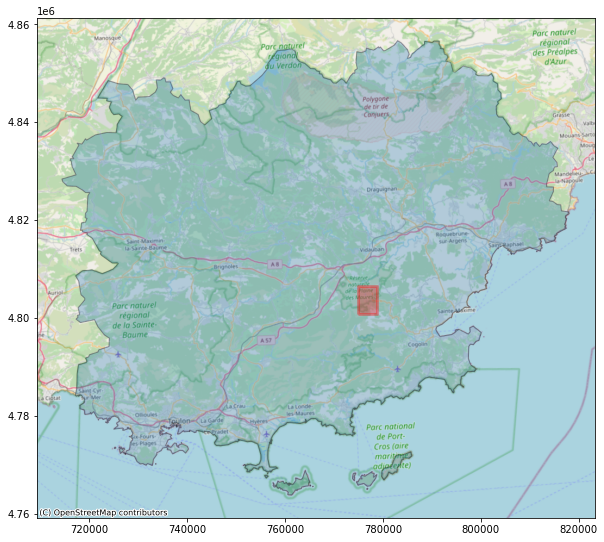

In [15]:
# load Var patch
eopatch = EOPatch.load('Patches/Var/Processed data/')
plot_dep(aoi=eopatch.bbox, name='Var', basemap='OSM', shapefile='Shapefiles/Départements/contours-des-departements-francais-issus-dopenstreetmap.shp')

### Run BFAST on year 2021

Our NDVI data base (`S2 data/Var/`) goes from start of 2018 to end of 2021. Here is how we have set the following parameters :

- `training period` : all data from 2018 to 2020 inlcuded
- `monitoring period` : all data from year 2021. We aim to see the changes during the full year 

The next cell sets these parameters and executes the BFAST algorithm (it is the same as in [section 7](#section7)).

In [19]:
# set BFAST parameters
end_train = datetime(2020,12,31)
start_monitor = datetime(2021,1,1)
end_monitor = datetime(2021,12,31)
bfast_model, valid_data_f, dates_f = set_bfast_params(valid_data, dates, ts_indices_preserved, end_train, start_monitor, end_monitor, trend=True, level=0.01)

# execute BFAST
breaks, magnitudes, means, valids = execute_bfast(bfast_model, valid_data_f, dates_f)

In [20]:
print("number of breaks detected :", (breaks>0).sum())
print("percentage of time series detected with an anomaly :", ((breaks>0).sum()/len(breaks))*100, '%')

number of breaks detected : 2770
percentage of time series detected with an anomaly : 76.94444444444444 %


### Results

After applying BFAST, it is necessary to organise the results obtained to perform the best possible analysis. The function `organise_results` organises them in a table format where a row corresponds to a time serie :

- `geometry`: spacial geometry of the superpixel,
- `breakpoint` : The date at which the breakpoint was detected in the time series. NaT if no breakpoint detected,
- `magnitude` : The magnitude computed,
- `norm_mag` : The magnitude normalized.

In [16]:
results = organise_results(time_series_forest, dates_f, start_monitor, breaks, magnitudes)
results.head()

VALUE                                           geometry breakpoint  \
0   16.0  POLYGON ((775788.977 4806542.436, 775898.868 4... 2021-10-06   
1   28.0  POLYGON ((776797.978 4806542.436, 776927.849 4...        NaT   
2   49.0  POLYGON ((778406.385 4806542.436, 778516.277 4... 2021-10-01   
3   35.0  POLYGON ((777377.404 4806542.436, 777537.246 4...        NaT   
4    0.0  POLYGON ((774929.827 4806542.436, 774969.788 4... 2021-10-01   

     magnitude  norm_mag  
0 -1105.977295 -0.102199  
1   331.318268  0.042008  
2 -1164.116455 -0.107572  
3  1433.217773  0.181717  
4 -1970.744385 -0.182109

### Regrouping breakpoints

For our case, we need to locate the anomalies which means we need to know which superpixels were detected at a specific date. The following function regroups the number of superpixels detected abnormal for each date :
- `n_superpixels` : The number of superpixels abnormal to the corresponding date,
- `magnitude_min` : The minimum magnitude of all abnormal superpixels to the corresponding date,
- `magnitude_max` : The maximum magnitude of all abnormal superpixels to the corresponding date,
- `magnitude_mean` : The magnitude mean of all abnormal superpixels to the corresponding date,
- `magnitude_median` : The magnitude median of all abnormal superpixels to the corresponding date,

For example, 1 superpixel was detected abnormal the 18th of July 2021 whereas 215 superpixels where detected abnormal on the 22nd of August 2021

In [17]:
breakpoint_df = group_by_breakpoints(results)
breakpoint_df

breakpoint  VALUE_count  magnitude_min  magnitude_max  magnitude_mean  \
0  2021-03-20            1    7887.068359    7887.068359     7887.068359   
1  2021-03-30            2    4708.239258    5653.706055     5180.972656   
2  2021-04-04            1    6986.595215    6986.595215     6986.595215   
3  2021-04-14            1   -5165.318359   -5165.318359    -5165.318359   
4  2021-04-19            2   -1306.820312    6801.804199     2747.491943   
5  2021-05-04            2    3687.644775    5006.296875     4346.970703   
6  2021-05-09            3  -10821.770508   -4269.393066    -7000.277344   
7  2021-05-14            2    3001.032715    3688.123535     3344.578125   
8  2021-05-29            2    3529.567139    3885.367188     3707.467285   
9  2021-06-03            9   -8830.360352    4373.617188    -5219.906738   
10 2021-06-08            9   -7682.939941    2716.545898    -4412.472656   
11 2021-06-13            5   -6277.540039    4006.093994    -3384.561768   
12 2021-06-18            6   -4752.517578   -1734.373535    -3423.451172   
13 2021-07-03            8   -6523.371582   -1723.105713    -4317.235352   
14 2021-07-13            5   -8545.157227    3877.685303     -583.870544   
15 2021-07-18            1   -3700.970459   -3700.970459    -3700.970459   
16 2021-07-23            3   -5728.279785    3086.727539     -235.226883   
17 2021-07-28            8   -6511.846680    3413.338135      592.010864   
18 2021-08-02            1   -4211.528809   -4211.528809    -4211.528809   
19 2021-08-07            8   -6067.158691    1219.874878    -3595.505615   
20 2021-08-17           82   -8670.361328   -3231.592041    -5629.433594   
21 2021-08-22          215   -9502.117188    2316.620361    -5015.188477   
22 2021-08-27          269   -9873.708984   -1924.867432    -4792.604004   
23 2021-09-01          291   -9119.680664    -893.400452    -3935.978027   
24 2021-09-06          366   -9641.613281    -592.170410    -2999.363525   
25 2021-09-11          354   -8382.389648    -253.152283    -2320.986328   
26 2021-09-21          301   -8295.152344     120.625092    -1686.908691   
27 2021-10-01          227   -6394.091797     943.959839    -1227.917114   
28 2021-10-06          132   -4169.248047    1044.644531     -961.406860   
29 2021-10-11           92   -3830.160889     913.648804     -942.292664   
30 2021-10-16           95   -3572.651367    1592.678345     -757.263428   
31 2021-10-26           64   -3454.126465    1096.553833     -836.389771   
32 2021-11-05           68   -4970.416016    2287.316406     -772.432434   
33 2021-11-20           44   -5493.689453    1208.367920     -708.372925   
34 2021-11-30           41   -3634.360596    2225.476318     -400.133514   
35 2021-12-05           25   -3778.351318    2086.822998     -426.799286   
36 2021-12-10            3   -3054.161621    1787.177368     -286.676697   
37 2021-12-20           22   -2467.825439    2017.828125     -240.891235   

    magnitude_median  
0        7887.068359  
1        5180.972656  
2        6986.595215  
3       -5165.318359  
4        2747.491943  
5        4346.970703  
6       -5909.668945  
7        3344.578125  
8        3707.467285  
9       -6126.991699  
10      -4358.147949  
11      -4932.910156  
12      -3306.104492  
13      -4272.102539  
14       3046.471680  
15      -3700.970459  
16       1935.871582  
17       2217.767090  
18      -4211.528809  
19      -3955.658936  
20      -5415.491211  
21      -4913.333496  
22      -4439.090820  
23      -3559.166504  
24      -2578.152344  
25      -1943.530884  
26      -1414.405762  
27      -1018.768372  
28       -832.931274  
29       -848.120972  
30       -680.556213  
31       -761.026794  
32       -692.625732  
33       -490.360962  
34       -432.994385  
35       -486.979767  
36        406.954193  
37       -304.644928

The following cell filters only the dates where the most breakpoints appear in our time series (over 5% time series abnormal) :

In [18]:
# display dates with a large amount of breakpoints detected

# 5% threshold
threshold = 0.05
# total forest superpixels
n_superpixels = len(results.index)

# apply query
breakpoint_df.query("@threshold*@n_superpixels <= VALUE_count")

breakpoint  VALUE_count  magnitude_min  magnitude_max  magnitude_mean  \
21 2021-08-22          215   -9502.117188    2316.620361    -5015.188477   
22 2021-08-27          269   -9873.708984   -1924.867432    -4792.604004   
23 2021-09-01          291   -9119.680664    -893.400452    -3935.978027   
24 2021-09-06          366   -9641.613281    -592.170410    -2999.363525   
25 2021-09-11          354   -8382.389648    -253.152283    -2320.986328   
26 2021-09-21          301   -8295.152344     120.625092    -1686.908691   
27 2021-10-01          227   -6394.091797     943.959839    -1227.917114   

    magnitude_median  
21      -4913.333496  
22      -4439.090820  
23      -3559.166504  
24      -2578.152344  
25      -1943.530884  
26      -1414.405762  
27      -1018.768372

We can see that the period of end of August and September appears to have problems. Let's dig deeper.

There is a better way to visualise when and how much the NDVI of our time series was impacted. The `plot_breakpoints` function is a graph bar that brings us two important piece of information :
- The number of breaks detected per dates
- The intensity of the changes : The darker the bar, the stronger the NDVI changes are

\
This tells us that a lot of changes in the NDVI happen starting on the 17th of August 2021. This corresponds perfectly to the start of the fire (16 August 2021 as a reminder). The algorithm then keeps detecting changes as time goes on. Many in September and a few more in October. This can be explained by the fact that some areas were less heavily affected by the fire than others and that the algorithm needed more material (so to speak acquisitions) to be sure to classify the time series as abnormal

\
Furthermore, the colour coding of the bars validates this observation. The largest NDVI variations, in dark blue, were detected very early in the time series (between late August and early September) whereas the smaller variations, in lighter blue, were detected a little later (between late September and early October). This gives us this very nice blue gradient over time from the start of the fire.

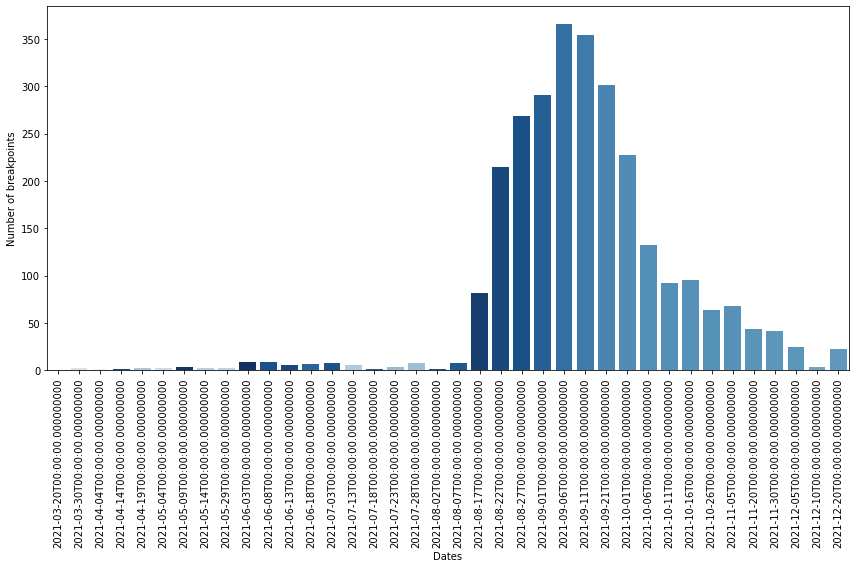

In [24]:
plot_breakpoints(breakpoint_df, func='median')

### Damage mapping

Now that we have dated the anomalies, it is interesting to look at the spatial side to see the extent of the damage and especially to get an idea of which areas were hardest hit by the fire.

As [previously stated](#section7), the `magnitude` value corresponds to the median of the difference between the data and the model prediction in the monitoring period.

As we know that the damage occurred in August and September, and this was confirmed by the results of the 2021 study, we can re-run BFAST specifying only the August and September period. In this way, the `magnitude` will be computed in this two months time and will enable us to elaborate a nice damage mapping.

In [21]:
# set BFAST parameters
end_train = datetime(2020,12,31)
start_monitor = datetime(2021,8,1)
end_monitor = datetime(2021,9,30)
bfast_model, valid_data_f, dates_f = set_bfast_params(valid_data, dates, ts_indices_preserved, end_train, start_monitor, end_monitor, trend=True, level=0.01)

# execute BFAST
breaks, magnitudes, means = execute_bfast(bfast_model, valid_data_f, dates_f)

# organise results
results = organise_results(time_series_forest, dates_f, start_monitor, breaks, magnitudes)

The following plot shows the `norm_magnitude` of every time series (superpixels). In other terms it shows the intensity of NDVI changes over the monitoring period (here August/Semptember 2021). The more red a superpixel is, the more its NDVI value has been affected compared to previous years. This means very high fire activity.

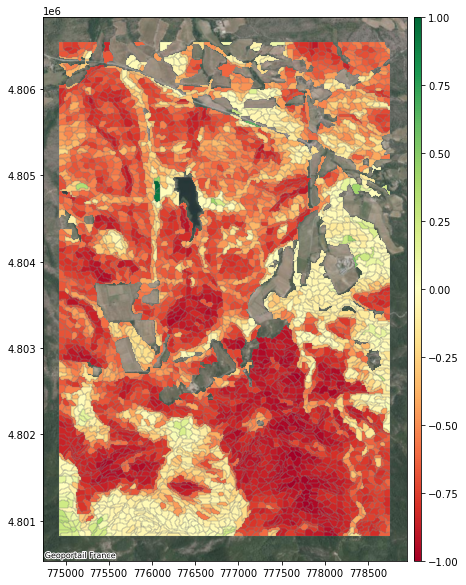

In [22]:
plot_magnitudes(results, time_series_forest)

### Real time observation

Let's imagine that we want to detect a phenomenon in real time, i.e. as soon as it appears. This could apply to fires but also to other phenomena (this is the purpose of [use case 2](#section9)). 

The idea is the following :
- Set a fixed training period
- Establish a short test period (about 2-3 months)
- Slide this test window to each new Sentinel-2 acquisition available on WEkEO
- Apply BFAST each time the window is shifted by one date. 

<p align="center">
     <img src='./Images/sld_window.png' alt="drawing" width="1000">
</p>

In the next cell we set our sliding window to a 3-month size starting at the very beginning of 2021. We then apply the `bfast_dynamic` function that runs BFAST everytime we shift the sliding window by one date.

In [24]:
# set end of training date
end_train = datetime(2020,12,31)

# set start and end date of first window
first_window=[datetime(2021,1,1), datetime(2021,4,1)]

# apply bfast over time (simulation)
list_breaks, list_magnitudes, list_results, window_dates = bfast_dynamic(valid_data, dates, ts_indices_preserved, end_train=end_train, first_window=first_window)

  0%|          | 0/55 [00:00<?, ?it/s]

Now that we have applied BFAST multiple times accross 2021. 

In [25]:
def count_breaks(l):
    return (l>0).sum()

# grouping breakpoints dataframes
breakpoint_dfs = []
for res in list_results:
    breakpoint_dfs.append(group_by_breakpoints(res))

# compute maximum breakpoint for one date
max_bp = 0
for df in breakpoint_dfs:
    max_ = df['VALUE_count'].sum()
    if max_ > max_bp:
         max_bp = max_ 

# number of breaks detected for every window
n_breaks_list = list(map(count_breaks, list_breaks))

print('=== 1ST PLOT ===')
print('>> Saving images')
filenames = []
for i in tqdm(range(len(n_breaks_list))):
    filenames = live_breaks(n_breaks_list[:i+1], window_dates[i], filenames, i, path='Images/GIFs/', max_bp=max_bp)
    
frames = []
for filename in filenames:
    frames.append(imageio.imread(filename))

print('>> Saving GIF')
imageio.mimsave('Images/GIFs/real_time_breaks.gif', frames, format='GIF', duration=0.5)

print('>> Removing Images\n')
# Remove files
for filename in set(filenames):
    os.remove(filename)
print('>> DONE !')

print('=== 2ND PLOT ===')
print('>> Saving images')
filenames = []
for i in tqdm(range(len(list_results))):
    filenames = live_mag(list_results[i], window_dates[i], filenames, i, path='Images/GIFs/')

frames = []
for filename in filenames:
    frames.append(imageio.imread(filename))

print('>> Saving GIF')
imageio.mimsave('Images/GIFs/real_time_magnitudes.gif', frames, format='GIF', duration=0.5)

print('>> Removing Images\n')
# Remove files
for filename in set(filenames):
    os.remove(filename)
print('>> DONE !')

>> Saving GIF
>> Removing Images

>> DONE !


Breaks detection over time            |  Damage mapping over time
:-------------------------:|:-------------------------:
![SegmentLocal](./Images/GIFs/real_time_breaks.gif )| ![SegmentLocal](./Images/GIFs/real_time_magnitudes.gif)

We are now able to see the changes in real time. Visually, we can see that trouble in our NDVI time series happen right at the beginning of the fire, starting when we take in consideration the 17th of August Sentinel-2 data.
\
The advantage of this technique is that we can apply it every time we get a new acquisition of Sentinel-2 data on WEkEO and therefore be aware of the changes in NDVI in real time within our area of interest.

# <a id='section9'></a>9. USE CASE 2 : Monitor parasite attacks on trees, example in Lot region (France)
[Back to top](#TOC_TOP)

For use case number 2, we will study the impact of an insect, the Gypsy Moth, on the Lot forests (France). Researchers have observed a defoliation of the vegetation during the May-June period of the years 2020 and 2021. It is therefore interesting to see what can bring the study of Sentinel-2 data to understand and monitor this phenomenon.

In order not to overload the notebook, the processing chain has been deliberately gathered into a single cell. However, the processing chain is identical and all the data is available in the next cell for you to run. The steps to follow are those in sections 3, 4, 5 & 6, changing from `Var` data to `Lot` data

In [ ]:
""" PROCESSING CHAIN FOR USE CASE 2 (same as for use case 1)"""

use_case = 'Lot' #use case 2

#empty file list
spatial_files = []

# path
directory = 'S2 data/' + use_case + '/'

# walk through directory
for path, subdirs, files in os.walk(directory):
    for name in sorted(files):
        if name[-3:] == "gml" or name[-3:] == "jp2":
            file_path = os.path.join(path, name)
            spatial_files.append(file_path)
            
# sort file list
spatial_files = sorted(spatial_files)


# set bounding boxes of both use cases
if use_case == 'Var':
    aoi = [6.39, 43.31, 6.44, 43.36] #WSG84 CRS
else:
    aoi = [1.52, 44.45, 1.62, 44.50] #WSG84 CRS
    
# create a bounding box object from the aoi coordinates
bbox = BBox(aoi, CRS.WGS84)

# Transform the coordinates to UTM 31N
bbox = bbox.transform(CRS.UTM_31N)

timestamp = []
for i in tqdm(range(0, len(spatial_files), 3)):
    year = spatial_files[i][12:16]
    month = spatial_files[i][17:19]
    day = spatial_files[i][19:21]

    # open band4 et band8 acquisition
    band4 = rio.open(spatial_files[i+1])
    band8 = rio.open(spatial_files[i+2])
    
    # convert to int16
    band4_int = band4.read().squeeze().astype('int16')
    band8_int = band8.read().squeeze().astype('int16')

    # compute ndvi
    ndvi = ((band8_int - band4_int) / (band8_int + band4_int)).astype('float32')
    try:
        # open cloud shapes
        clm = gpd.read_file(spatial_files[i])

        # keep shapes intersecting aoi
        clm_clipped = clm.intersection(bbox.geometry)
        clm_clipped = clm_clipped[~clm_clipped.is_empty]
        
        if len(clm_clipped.index) == 0:
            # case : no cloud coverage
            clip_clm = np.zeros(band4_int.shape)
        
        else:
            # case : cloud coverage
            clip_clm, _ = mask(band4, clm_clipped)

        # set pixel to 1 if covered by cloud, 0 otherwise
        clc_mask = np.where(clip_clm <= 0, 0, 1).astype('uint8')

    except ValueError:
        # case no clouds on whole sentinel2 tile
        clip_clm = np.zeros(band4_int.shape)
        clc_mask = np.where(clip_clm <= 0, 0, 1).astype('uint8')
    
    if i==0:
        # initialise variables
        ndvi_stack = np.expand_dims(ndvi, axis=0)
        clc_mask_stack = np.expand_dims(clc_mask.squeeze(), axis=0)
    else:
        # stack newly computed ndvi and cloud mask
        ndvi_stack = np.vstack((ndvi_stack, np.expand_dims(ndvi, axis=0)))
        clc_mask_stack = np.vstack((clc_mask_stack, np.expand_dims(clc_mask.squeeze(), axis=0)))
    
    # append new timestamp
    timestamp.append(datetime(int(year), int(month), int(day)))
    
eopatch = EOPatch()

# fill eopatch
eopatch[FeatureType.DATA, "NDVI"] = np.expand_dims(ndvi_stack, axis=3)
eopatch[FeatureType.MASK, "CLM"] = np.expand_dims(clc_mask_stack, axis=3)
eopatch[FeatureType.BBOX] = BBox(bbox.geometry.bounds, CRS.UTM_31N)
eopatch[FeatureType.TIMESTAMP] = timestamp

# save eopatch
eopatch.save('Patches/' + use_case + '/Raw_data')

# setting the slic segmentation task
slic_segmentation_task = SlicSegmentationTask((FeatureType.DATA, 'NDVI_STANDARD'), 
                                       (FeatureType.MASK_TIMELESS, 'SUPER_PIXELS'),
                                      n_segments=10000, compactness=0.0001, sigma=1)

# standardize the NDVI
eopatch.data['NDVI_STANDARD'] = stats.zscore(eopatch.data['NDVI'], nan_policy='omit')

# freeing memory
del eopatch.data['NDVI']

# execute the superpixel task
eopatch = slic_segmentation_task.execute(eopatch)
eopatch.mask_timeless['SUPER_PIXELS'] = eopatch.mask_timeless['SUPER_PIXELS'].astype(np.int32)

# execute the raster to vector task
eopatch = raster_to_vector_task.execute(eopatch)

# save the processed eopatch
eopatch.save("Patches/" + use_case + "/Processed data")

On the following diagram, you can see the department of Lot (blue) and the studied area (red)

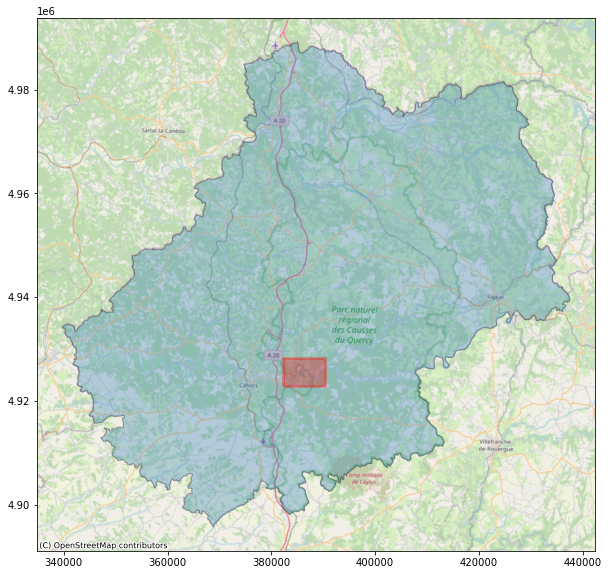

In [26]:
eopatch = EOPatch.load('Patches/Lot/Processed data/')
plot_dep(aoi=eopatch.bbox, name='Lot', basemap='OSM', shapefile='Shapefiles/Départements/contours-des-departements-francais-issus-dopenstreetmap.shp')

The processing chain is similar to that of the previous use case. Once this has been done, we can apply BFAST and analyse the results obtained.

In [27]:
valid_data, dates = get_valid_data(eopatch=eopatch)
time_series_forest, ts_indices_preserved = get_forest_time_series(eopatch=eopatch, shapefile='Shapefiles/Forêts Lot/Formation_végétale_Lot.shp', filter_percentage=0.8)

66.76 % of time series preserved


### Apply BFAST

In order to see and date the defoliation phenomenon, we will run BFAST in early 2021, taking into account only the years 2018 and 2019 as training period. The 2020 period, which is also affected, could compromise the results.

In [28]:
end_train = datetime(2019,12,31)
start_monitor = datetime(2021,1,1)
end_monitor = datetime(2021,12,31)
bfast_model, valid_data_f, dates_f = set_bfast_params(valid_data, dates, ts_indices_preserved, end_train, start_monitor, end_monitor)

print("total period :", dates[0], "to", end_monitor.date(), "==>", valid_data_f.shape[0], "dates")
print("training period :", dates[0], "to", end_train.date())
print("monitoring period :", start_monitor.date(), "to", end_monitor.date())

total period : 2018-01-01 to 2021-12-31 ==> 215 dates
training period : 2018-01-01 to 2019-12-31
monitoring period : 2021-01-01 to 2021-12-31


In [29]:
breaks, magnitudes, means = execute_bfast(bfast_model, valid_data_f, dates_f)

In [30]:
print("number of breaks detected :", (breaks>0).sum())
print("percentage of time series detected with an anomaly :", ((breaks>0).sum()/len(breaks))*100)

number of breaks detected : 1930
percentage of time series detected with an anomaly : 59.919279726792915


### Results

Similarly to the previous use case, we organise the results obtained from the BFAST execution.

In [31]:
results = organise_results(time_series_forest, dates_f, start_monitor, breaks, magnitudes)
results.head()

VALUE                                           geometry breakpoint  \
0   76.0  POLYGON ((389572.871 4928335.296, 389572.871 4...        NaT   
1    0.0  POLYGON ((382242.549 4928335.296, 382242.549 4...        NaT   
2    1.0  POLYGON ((382332.552 4928335.296, 382332.552 4...        NaT   
3    3.0  POLYGON ((382502.560 4928335.296, 382502.560 4... 2021-09-17   
4    4.0  POLYGON ((382592.564 4928335.296, 382592.564 4...        NaT   

     magnitude  norm_mag  
0  1383.351562  0.281375  
1   617.037720  0.125506  
2   631.107300  0.128368  
3  -618.694519 -0.089349  
4   -53.749939 -0.007762

### Regrouping breakpoints

To better understand when the breakpoints occured in our time series, we regroup them by date of appearances.

In [32]:
breakpoint_df = group_by_breakpoints(results)
breakpoint_df

breakpoint  VALUE_count  magnitude_min  magnitude_max  magnitude_mean  \
0  2021-03-31            1    -619.319458    -619.319458     -619.319458   
1  2021-04-30            3   -2204.797363   -1359.610962    -1794.237305   
2  2021-05-05           20   -2736.516602     364.216736     -907.858704   
3  2021-05-25           22   -2122.307373     453.320862     -734.950317   
4  2021-05-30           19   -6924.444336    1654.309082    -1803.326538   
5  2021-06-09           17   -3383.273926   -1163.223755    -2164.956543   
6  2021-06-14           47   -3473.782227    3523.342285    -1937.519409   
7  2021-06-19          130   -5610.958984    1076.739136    -1657.416626   
8  2021-06-29          119   -3007.772461    2111.379395     -764.027649   
9  2021-07-09          159   -3120.363525    1411.309082    -1021.033752   
10 2021-07-14          342   -3455.791504    1989.469116     -666.473206   
11 2021-07-19           78   -2982.215820    1108.376465     -980.761597   
12 2021-07-24          174   -3072.397461    2150.121338     -908.836426   
13 2021-07-29          384   -3160.437744    1977.013916     -526.881958   
14 2021-08-08           73   -2246.550781    1548.344360     -384.456360   
15 2021-08-23           70   -2509.107666    1262.489258     -690.103577   
16 2021-08-28           18   -2159.619385    4916.395508     -853.286865   
17 2021-09-17           85   -2390.457764    2524.668701     -183.899429   
18 2021-09-22            4   -1862.415771     459.846527     -787.855469   
19 2021-10-12            9   -1484.361938    2961.081055       55.328995   
20 2021-10-17            6    -921.311523    2950.567383      271.254639   
21 2021-10-22           72   -2254.666748    2086.237793     -279.918274   
22 2021-10-27           13   -2060.004150    3607.188477     -130.292496   
23 2021-11-01           21   -2062.833740     566.347473     -503.643372   
24 2021-11-06           17    -920.594604    2346.601318        7.822563   
25 2021-11-11            4    -937.496399    3346.579834     1476.591187   
26 2021-12-11           11   -1277.524414    1322.048584     -331.901306   
27 2021-12-16            5    -556.484253    3978.411377     1023.463806   
28 2021-12-21            7    1110.320190    4606.053223     2343.413574   

    magnitude_median  
0        -619.319458  
1       -1818.303589  
2        -925.560913  
3        -767.775085  
4       -2025.860352  
5       -2151.265869  
6       -1998.839844  
7       -1678.637451  
8        -820.671143  
9       -1131.418213  
10       -597.699097  
11      -1061.920166  
12       -910.375916  
13       -611.194702  
14       -336.095795  
15       -701.926453  
16      -1138.250000  
17       -343.395996  
18       -874.426331  
19       -396.920288  
20        -54.042366  
21       -451.047180  
22       -962.803833  
23       -491.002380  
24       -410.783569  
25       1748.640625  
26       -369.846008  
27         90.759941  
28       2148.749023

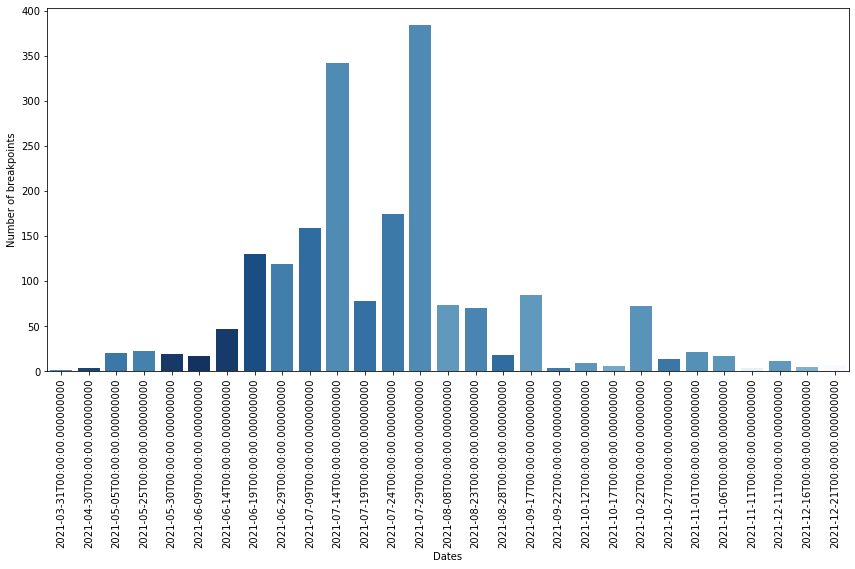

In [33]:
plot_breakpoints(breakpoint_df, func='median')

The results displayed on the previous graph corroborate the ground truth. Indeed, the strongest changes in NDVI happen during the May-June period. Also, we can observe that a lot of breakpoints are detected during July. This can be explained that after a strong defoliation caused by the Gypsy Moth during May and June, trees had to go through a leave regrowth during summer, a different behaviour compared to years 2018 and 2019. Simply, trees didn't need to iniate such a regrowth because they were not harmed at first by the insect.

## Damage mapping

Knowing that the Gypsy Moth acts during the end of spring and beginning of summer, we can easily adjust our analysis to map the damage it may have caused in the region of interest. In this way we apply BFAST again but changing the monitoring period to avoid dates that could interfere on our results.

In [35]:
# set BFAST parameters
end_train = datetime(2020,1,1)
start_monitor = datetime(2021,4,1)
end_monitor = datetime(2021,6,30)
bfast_model, valid_data_f, dates_f = set_bfast_params(valid_data, dates, ts_indices_preserved, end_train, start_monitor, end_monitor)

# execute BFAST
breaks, magnitudes, means = execute_bfast(bfast_model, valid_data_f, dates_f)

# organise results
results = organise_results(time_series_forest, dates_f, start_monitor, breaks, magnitudes)

# group breakpoints
breakpoint_df = group_by_breakpoints(results)

Similarly to use case number 1, the following plot shows the `norm_magnitude` of every time series (superpixels). In other terms it shows the intensity of NDVI changes over the monitoring period. The more red a superpixel is, the more its NDVI value has been affected compared to previous years. This means very high Gypsy Moth activity.

With this type of graph, we are able to see the intensity of the impact of Gypsy Moth and on top of that we are able to locate it geographically.

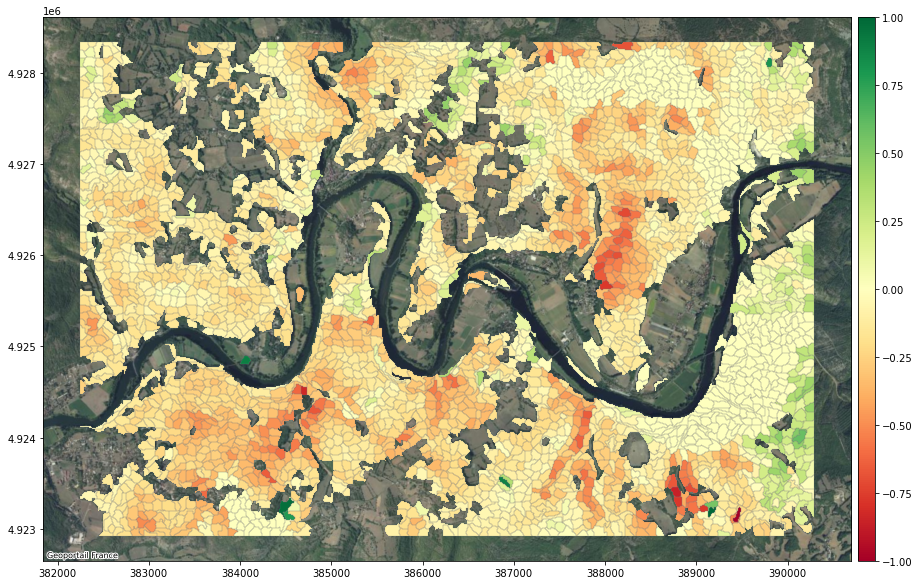

In [36]:
plot_magnitudes(results, time_series_forest)

## Gypsy Moth spatial progress (2021)

One of the many advantages of BFAST is that it is able to date anomalies. The following graph tracks the progress and acceleration of the Gypsy Moth in space. The colour code only refers to the date when the anomalies appeared. The lighter the colour, the earlier the anomaly was detected. An animated GIF image is the perfect way to visually see the spatial advance of the Gypsy Moth :

In [37]:
print('>> Saving images')
filenames = []
for i in tqdm(range(len(breakpoint_df.breakpoint))):
    filenames = plot_high_changing_sectors(eopatch, breakpoint_df,start_monitor, breakpoint_df.breakpoint[i], filenames, i, path='Images/GIFs/')

frames = []
for filename in filenames:
    frames.append(imageio.imread(filename))

print('>> Saving GIF')
imageio.mimsave('Images/GIFs/gypsy_moth_progress_2021.gif', frames, format='GIF', duration=1)

print('>> Removing Images\n')
# Remove files
for filename in set(filenames):
    os.remove(filename)
print('>> DONE !')

>> Saving images


  0%|          | 0/7 [00:00<?, ?it/s]

>> Saving GIF
>> Removing Images

>> DONE !


Gypsy Moth progress over time (May-June 2021) |
:-------------------------:|
![SegmentLocal](./Images/GIFs/gypsy_moth_progress_2021.gif )

### Damage at town level

We have applied our processing chain only on a small area of interest of the Lot department. Let's see how we can extend our study to the whole department and locate the most damaged areas.

The principle is the following :

    1. Cut the Lot department into multpile small area of interests. In our case, we will use the towns shapefile of the department.
    2. Apply BFAST on each small town area
    3. Compute the number of time series affected by the Gypsy Moth (only relevant if superpixels are very close in size, which they are here)
    4. Store the results into a geojson file. File is located in the Patches/Lot/ folder.
    5. Plot result for a good visualisation
    

In [14]:
# read towns shapefile
towns = gpd.read_file('Patches/Lot/town_study_results.geojson')
towns.head()

insee                 nom              wikipedia  surf_ha     ratio  \
0  46032          Boissières    fr:Boissières (Lot)   1311.0  0.279776   
1  46156  Bellefont-La_Rauze  fr:Bellefont-La Rauze   3769.0  3.956273   
2  46145    Lachapelle-Auzac    fr:Lachapelle-Auzac   3144.0  0.325866   
3  46118              Gignac        fr:Gignac (Lot)   4091.0  0.171920   
4  46304          Séniergues          fr:Séniergues   1829.0  0.000000   

                                            geometry  
0  POLYGON ((1.37289 44.55161, 1.37293 44.55176, ...  
1  POLYGON ((1.44956 44.49430, 1.44957 44.49447, ...  
2  POLYGON ((1.43552 44.96220, 1.43553 44.96222, ...  
3  POLYGON ((1.40910 45.00683, 1.40926 45.00685, ...  
4  POLYGON ((1.51527 44.69643, 1.51528 44.69652, ...

The `towns` variable contains the result of BFAST applied to more than half the towns in the Lot department. The `ratio` column is the percentage of forest superpixel that have been detected abnormal during the Spring period in 2021. In the following plot, we can see that the area that has been heavily touch by the Gipsy Moth is the middle south of the department.

NameError: name 'eopatch' is not defined

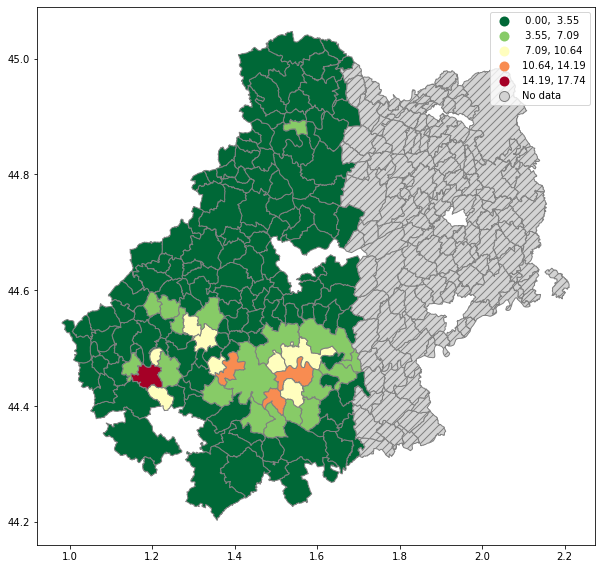

In [15]:

# plot results
fig, ax = plt.subplots(ncols=1, figsize=(10,10))
towns.plot(ax=ax, column='ratio', cmap='RdYlGn_r', scheme='equalinterval', legend=True, edgecolor='grey', missing_kwds={"color": "lightgrey",
        "edgecolor": "grey",                                                                              
        "hatch": "///",
        "label": "No data"})
cx.add_basemap(ax=ax, crs=eopatch.bbox.crs.epsg, source=cx.providers.OpenStreetMap.Mapnik)
ax.set_title('Town map : abnormal series ratio')

<hr>

This is the end of the Notebook. You can now apply the cells to your own use case by selecting a different aera of interest. Note that you will also need to either find the forest shapefile of the new area of interest or to skip the forest filtering part.

Hope you enjoyed reading !